# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# data processing libraries
import numpy as np
import pandas as pd



# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time

# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

# delete empty columns
del azdias['Unnamed: 0']
del customers['Unnamed: 0']

<string>:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 1min 35s


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**DataFrame sizes**

In [5]:
print("AZDIAS dataframe size\nrows: {}\ncols: {}".format(*azdias.shape))

AZDIAS dataframe size
rows: 891221
cols: 366


In [6]:
print("CUSTOMERS dataframe size\nrows: {}\ncols: {}".format(*customers.shape))

CUSTOMERS dataframe size
rows: 191652
cols: 369


### 0.1 Load DataFrame with information about all attributes

1. read `DIAS Attributes - Values 2017.xlsx` file into pandas DataFrame,
2. iterate over rows, read each unique attributes name and add meanings and value  rows into list,
3. read `DIAS Information Levels - Attributes 2017.xlsx` file into pandas DataFrame,
4. join both DataFrames on Attribute and Description columns into one DataFrame.

In [7]:
# 1. read `DIAS Attributes - Values 2017.xlsx` file into pandas DataFrame
df_attr_1 = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del df_attr_1['Unnamed: 0']
df_attr_1.head(6)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown


In [8]:
# 2. iterate over rows, read each attributes name, description and value meanings,
rows = list()
start = False
for idx in df_attr_1.index:
    if df_attr_1.iloc[idx].Attribute is not np.nan:
        if start:
            rows.append([attribute, description, values, meanings])
        # create lists to store Values and Meanings
        values = list()
        meanings = list()
        # read data
        attribute = df_attr_1.iloc[idx].Attribute
        description = df_attr_1.iloc[idx].Description
        # just quick and ungly way to skip saving first row
        start = True
        
    # add values and meanings to the lists
    values.append(df_attr_1.iloc[idx].Value)
    meanings.append(df_attr_1.iloc[idx].Meaning)
    
rows.append([attribute, description, values, meanings])

df_attr_1 = pd.DataFrame(rows, columns=["Attribute", "Description", "Values", "Meanings"])
df_attr_1.head()

,Attribute,Description,Values,Meanings
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ..."
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y..."
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ..."
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]"
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)]


In [9]:
# 3. read DIAS Information Levels - Attributes 2017.xlsx file into pandas DataFrame
df_attr_2 = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
del df_attr_2['Unnamed: 0']
df_attr_2.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


There are 5 attribute names which were written in inconvienient manner:

* `D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24`,
* `D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24`,
* `D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24`,
* `D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24`,
* `D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24`.

These attributes will be manually fixed in cells bellow.

In [10]:
attr_list = ["D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24",
            "D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24",
            "D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24",
            "D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24",
            "D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24"]

# get rows of attributes of interest into new DataFrame
df_attr_3 = df_attr_2[df_attr_2.Attribute.isin(attr_list)]

# remove those attribrutes from DataFrame 
df_attr_2 = df_attr_2[~df_attr_2.Attribute.isin(attr_list)]

# check new DataFrame
df_attr_3.head()

,Information level,Attribute,Description,Additional notes
50,NaN,D19_GESAMT_ANZ_12 ...,transaction activity TOTAL POOL in the last 12...,NaN
51,NaN,D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and ...,NaN
52,NaN,D19_TELKO_ ANZ_12 D19_TELKO_ ...,transaction activity TELCO in the last 12 and ...,NaN
53,NaN,D19_VERSI_ ANZ_12 ...,transaction activity INSURANCE in the last 12 ...,NaN
54,NaN,D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12...,NaN


Creating a function which splits string into new strings was not an option because `D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24` would have two new strings `D19_GESAMT_ANZ_12` and `D19_GESAMT_ANZ_24`, but other attributes like `D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24` would result in 4 new strings `D19_BANKEN_`, `ANZ_12`, `D19_BANKEN_` and `ANZ_24`. Therefore I chose to just manualy iterate over rows and resave them into list->DataFrame.

In [11]:
# temprarry list to store data
_data = list()

for idx in df_attr_3.index:
    # split decription value with large space
    attributes = df_attr_3.loc[idx].Attribute.split("          ")
    # remove unneccesary spaces
    attribute_12 = attributes[0].replace(" ", "")
    attribute_24 = attributes[-1].replace(" ", "")
    
    # split decription value with " and "
    description = df_attr_3.loc[idx].Description.split(" and ")
    # create new descriptions for 12 and 24 months
    description_12 = description[0] + " months"
    description_24 = description[0][:-2] + description[1]
    
    # add information about 12 month attribute
    _data.append([np.nan, attribute_12, description_12, np.nan])
    # add information about 24 month attribute
    _data.append([np.nan, attribute_24, description_24, np.nan])
    
    
# resave data into DataFrame
df_attr_3 = pd.DataFrame(_data, columns=df_attr_3.columns)
df_attr_3.head()

,Information level,Attribute,Description,Additional notes
0,NaN,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,NaN
1,NaN,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,NaN
2,NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,NaN
3,NaN,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,NaN
4,NaN,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,NaN


In [12]:
# 4. join all DataFrames on Attribute and Description columns into one DataFrame.
df_attr = df_attr_2.append(df_attr_3, ignore_index=True)
df_attr = pd.merge(df_attr_1, df_attr, on=['Attribute'], how='outer')
# rename Description_x columns
# some descriptions for the same attribute differs in DataFrames, hence both descriptions are saved as separate columns
df_attr = df_attr.rename(columns={'Description_x': 'Description_a', 'Description_y': 'Description_i'})
df_attr = df_attr.reset_index(drop=True)
# del azdias['Description']
df_attr.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y...",Person,age through prename analysis,modelled on millions of first name-age-referen...
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ...",Household,main age within the household,NaN
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN


### 0.2 Attribute investigation

One would expect that `df_attr` Attribute column should contain all column values from `azdias` and `customer` DataFrames. With closer investigation (cell bellow) we can see that it is not the case.

In [13]:
A = set(azdias.columns)
B = set(customers.columns)
C = set(df_attr.Attribute) 

value_1 = A.difference(B)
value_2 = B.difference(A)
value_3 = A.difference(C)
value_4 = C.difference(A)

print(f"azdias DataFrame has {len(value_1)} more attributes than customers DataFrame.")
print(f"customers DataFrame has {len(value_2)} more attributes than azdias DataFrame.")
print(f"there are {len(value_3)} column values in azdias DataFrame which are not found in df_attr Attribute column.")
print(f"there are {len(value_4)} values in df_attr Attribute column which are not found among in azdias DataFrame columns.")

azdias DataFrame has 0 more attributes than customers DataFrame.
customers DataFrame has 3 more attributes than azdias DataFrame.
there are 90 column values in azdias DataFrame which are not found in df_attr Attribute column.
there are 46 values in df_attr Attribute column which are not found among in azdias DataFrame columns.


I created a dictonary `attr_dict` which would rename `azdias` columns to match feature names in `attr` Attribute column.

In [14]:
attr_dict = dict()

### 0.2.1 `D19_` attribute investigation

Then I did manual investigation of features using following lines of code:

```python
for _ in value_3:
    print(_)
```

and

```python
for _ in value_4:
    print(_)
```

I found many features in boths sets starting with `D19_`. I decided to filter out these features in more detail.

In [15]:
# create sets for D19 features in azdias and attr DataFrames

D19_azdias = set([_ for _ in value_3 if _[:4] == "D19_"])
D19_attr = set([_ for _ in value_4 if _[:4] == "D19_"])

1. Some feature names in `attr` had `_RZ` endings. With simple loop these features were added to `attr_dict` dictonary, e.g.

     `{'D19_ENERGIE': 'D19_ENERGIE_RZ'}`

In [16]:
# 1. rename D19 atributes which have `_RZ` ending 
for _ in D19_attr:
    if _[:-3] in D19_azdias:
        attr_dict[_[:-3]] = _

# drop these attributes from the D19 sets
D19_azdias = D19_azdias.difference(set(attr_dict.keys()))
D19_attr = D19_attr.difference(set(attr_dict.values()))

2. Two `D19_` attributes ('D19_BUCH_CD' and 'D19_KONSUMTYP_MAX') were manually mapped (I assume there was a typo in one of the documents):

    `{'D19_BUCH_CD': 'D19_BUCH_RZ', 'D19_KONSUMTYP_MAX': 'D19_KK_KUNDENTYP'}`
    
 

In [17]:
# 2. manually map two similiarly sounding attributes
attr_dict['D19_BUCH_CD'] = 'D19_BUCH_RZ'
attr_dict['D19_KONSUMTYP_MAX'] = 'D19_KK_KUNDENTYP'

# drop these attributes from the D19 sets
D19_azdias = D19_azdias.difference(set(['D19_BUCH_CD', 'D19_KONSUMTYP_MAX']))
D19_attr = D19_attr.difference(set(['D19_BUCH_RZ', 'D19_KK_KUNDENTYP']))

In [18]:
# check remaining D19 attributes
print(D19_azdias)
print(D19_attr)

{'D19_LETZTER_KAUF_BRANCHE', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_SOZIALES'}
set()


3. With some keyword searching in `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files I suspect that columns `D19_TELKO_ONLINE_QUOTE_12` and `D19_VERSI_ONLINE_QUOTE_12` should mean **actuality of the last transaction for the segment telecommunication ONLINE within the last 12 months** and **transaction activity INSURANCE ONLINE in the last 12 months**, respectively. Numeric values should represent the procentage of online-transactions within the last 12 months as in other columns with `QUOTE_12` endings.

In [19]:
# example of unique values with QUOTE_12 ending
azdias["D19_VERSAND_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  7.,  5.,  9.,  3.,  8.,  6.,  4.,  2.,  1.])

In [20]:
df_attr[df_attr.Attribute == "D19_VERSAND_ONLINE_QUOTE_12"]['Meanings'].iloc[0]

['no Online-transactions within the last 12 months',
 '10% Online-transactions within the last 12 months',
 '20% Online-transactions within the last 12 months',
 '30% Online-transactions within the last 12 months',
 '40% Online-transactions within the last 12 months',
 '50% Online-transactions within the last 12 months',
 '60% Online-transactions within the last 12 months',
 '70% Online-transactions within the last 12 months',
 '80% Online-transactions within the last 12 months',
 '90% Online-transactions within the last 12 months',
 '100% Online-transactions within the last 12 months']

In [21]:
azdias["D19_TELKO_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  5.,  7.,  3.])

In [22]:
azdias["D19_VERSI_ONLINE_QUOTE_12"].unique()

array([nan,  0., 10.,  5.,  7.,  8.,  6.,  3.,  9.])

4. I tried searching `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files with key words `LETZTER`, `KAUF`, `BRANCHE` and `SOZIALES`, but nothing meaningful was found. Therefore I decided to drop `D19_LETZTER_KAUF_BRANCHE` and `D19_SOZIALES` features from `azdias` DataFrame (**letter in cell X**).

In [23]:
for _ in D19_azdias:
    nan_ratio = azdias[_].isna().sum()/azdias.shape[0]
    print(f"{_} has {nan_ratio*100:.2f} % missing values.")

D19_LETZTER_KAUF_BRANCHE has 28.85 % missing values.
D19_TELKO_ONLINE_QUOTE_12 has 28.85 % missing values.
D19_VERSI_ONLINE_QUOTE_12 has 28.85 % missing values.
D19_SOZIALES has 28.85 % missing values.


In [24]:
for _ in D19_azdias:
    nan_ratio = customers[_].isna().sum()/customers.shape[0]
    print(f"{_} has {nan_ratio*100:.2f} % missing values.")

D19_LETZTER_KAUF_BRANCHE has 24.89 % missing values.
D19_TELKO_ONLINE_QUOTE_12 has 24.89 % missing values.
D19_VERSI_ONLINE_QUOTE_12 has 24.89 % missing values.
D19_SOZIALES has 24.89 % missing values.


From quick glance it seems that same users don't have information on these 4 columns.

### 0.2.2 other attribute investigation

Remaining attributes were investigated manualy by key-word searching `.xlxs` flies. Main remarks a listed here. Cells bellow only show arguments why some columns were renamed or removed.

1) Attributes which are in found `DIAS Attributes - Values 2017.xlsx` and `DIAS Information Levels - Attributes 2017.xlsx` files, but are not present among `azdias` DataFrame columns.


* **rename** `SOHO_FLAG` should be renamed with `SOHO_KZ`, there was probably a typo. For example, `TITEL_KZ` description is *flag whether this person holds an academic title*, similiar descriptions with word **flag** are for other attributes with `_KZ` endings, e.g.`OST_WEST_KZ`.


* **rename** `CAMEO_DEUINTL_2015` should be renamed with `CAMEO_INTL_2015`. Column `CAMEO_INTL_2015` unique values are similiar to `CAMEO_DEUINTL_2015` values provided by `.xlsx` files.


* **rename**  it seems that in `azdias` DataFrame column `KBA13_CCM_1401_2500` should be renamed to `KBA13_CCM_1400_2500`.


* **remove** no meaningul comparisons were found for `EINWOHNER`, `GEOSCORE_KLS7`, `GKZ`, `PLZ`, `PLZ8` and `WACHSTUMSGEBIET_NB` attributes.


* **remove** while `HAUSHALTSSTRUKTUR` sound similiar to `ANZ_STATISTISCHE_HAUSHALTE`, by closer inpection it was found that values differ a lot, `ANZ_STATISTISCHE_HAUSHALTE` contains numeric values >100, `HAUSHALTSSTRUKTUR` expects values in the range from -1 to 10.


* **remove** `BIP_FLAG` could be either `DSL_FLAG`, `HH_DELTA_FLAG` and `UNGLEICHENN_FLAG`. Some additional clarification is needed, hence these attributes will be droped. 


2) Attributes which are present among `azdias` DataFrame columns, but not found in `.xlsx` files.


* It seems that from `CJT_TYP_1` to `CJT_TYP_6` provides information about customer type. While this information is definetly important, these columsn ahd values from 1 to 5. If it was coded with 0s and 1s, indicating that client is TYP_1 or not TYP_1, then I would keep this data. For these reasons, I will drop all 6 columns.


* Intuitively one might guess that columns `ALTER_KINDX` provide information about age type/kind. Unfortunetly, these columns are not binary, therefore it has more information than person belongs to age type 1. For these reasons, I will remove `ALTER_KINDX` columns.

* Attributes with `KBA13_` prefix looks very simliar to attibutes with `KBA05_` prefix, e.g. `KBA13_ANTG1` and `KBA05_ALTER1`. On the other hand, descriptions of attributes with `KBA13_` prefix provide information about users with PLZ8 post code. One might think, that `KBA13_ANTG1` should be equivalent `PLZ8_ANTG1`. Unfortunetly, `azdias` DataFrame already contains columns `PLZ8_ANTG1`, which is different from `KBA13_ANTG1`.


**Keeping columns in `azdias` DataFrame with unknow information, would complicating unsupervided learning result analys, e.g. you will find `CJT_TYP_1` being one of the pricipal components, but you will not be able to explain shareholders, what that information means. For this reason, columns, for wich I couldn;t find explanations in `.xlsx` files will be droped from `azdias` DataFrame.**

In [25]:
# create sets for NOT D19 features in azdias and attr DataFrames

not_D19_azdias = set([_ for _ in value_3 if _[:4] != "D19_"])
not_D19_attr = set([_ for _ in value_4 if _[:4] != "D19_"])

In [26]:
not_D19_azdias

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_CCM_1401_2500',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KK_KUNDENTYP',
 'KOMBIALTER',
 'KONSUMZELLE',
 'LNR',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'SOHO_KZ',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11'}

In [27]:
not_D19_attr

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'EINWOHNER',
 'GEOSCORE_KLS7',
 'GKZ',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'PLZ',
 'PLZ8',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [28]:
azdias["PLZ8_ANTG1"].unique()

array([nan,  2.,  3.,  1.,  4.,  0.])

#### Rename `SOHO_KZ` with `SOHO_FLAG`

In [29]:
azdias["SOHO_KZ"].unique()

array([nan,  1.,  0.])

In [30]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Values']

306    [-1, 0, 1]
Name: Values, dtype: object

In [31]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Meanings'].values[0]

['unknown', 'no small office/home office', 'small office/home office']

In [33]:
df_attr[df_attr.Attribute == "SOHO_FLAG"]['Description_a']

306    small office/home office flag
Name: Description_a, dtype: object

In [34]:
# add entry to rename dictonary
attr_dict['SOHO_KZ'] = 'SOHO_FLAG'

#### Rename `CAMEO_INTL_2015` with `CAMEO_DEUINTL_2015`

In [35]:
azdias["CAMEO_INTL_2015"].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [36]:
df_attr[df_attr.Attribute == "CAMEO_DEUINTL_2015"]['Values'].values

array([list([-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55])],
      dtype=object)

In [39]:
df_attr[df_attr.Attribute == "CAMEO_DEUINTL_2015"]['Description_a'].values[0]

'CAMEO classification 2015 - international typology'

In [40]:
# add entry to rename dictonary
attr_dict['CAMEO_INTL_2015'] = 'CAMEO_DEUINTL_2015'

#### Rename `KBA13_CCM_1401_2500` with `KBA13_CCM_1400_2500`

In [41]:
attr_dict['KBA13_CCM_1401_2500'] = 'KBA13_CCM_1400_2500'

#### Compare `ANZ_STATISTISCHE_HAUSHALTE` with `HAUSHALTSSTRUKTUR`

In [42]:
azdias["ANZ_STATISTISCHE_HAUSHALTE"].unique()

array([ nan,  12.,   7.,   2.,   3.,   5.,   6.,   1.,  14.,   4.,  11.,
        13.,  30.,  22.,  36., 244.,  10.,  32.,   8.,   9.,  18.,  17.,
        16.,  67.,  19.,  15.,  26.,  20.,  23.,  33.,  34.,  68.,  53.,
        21.,  42.,  57.,  28.,  25.,  60.,  35.,  29.,  43.,  64.,  27.,
        46.,  24.,  48.,  31.,  56.,  37., 243., 157.,  39.,  40.,  71.,
        63.,  38.,  44.,  50., 101.,  66.,  41.,  81.,  47., 192., 131.,
       149.,  74.,  84.,  80., 137.,  45.,  94.,  65.,  54.,  87.,  69.,
       125.,  61.,  82.,  73.,  72.,  86., 292.,  70.,  83.,  91., 112.,
        58.,  51.,  75.,  52.,  90., 140.,  49., 212.,  79., 152., 142.,
       166., 251.,  99., 107.,  76., 173.,  89., 138.,  92., 154., 115.,
       100.,  55., 116.,  88., 113., 162.,  95., 168.,  62.,  97., 110.,
       127., 102.,  93., 103.,  78., 111., 114.,  77.,  98., 365., 146.,
       109.,  59., 108., 289., 130.,  85., 119., 159., 183., 117., 303.,
        96., 124., 163., 123., 122., 156., 155.,   

In [43]:
df_attr[df_attr.Attribute == "HAUSHALTSSTRUKTUR"]['Values'].values

array([list(['-1, 0', 1, 2, 3, 4, 5, 6, 7, 8, 9])], dtype=object)

#### Investigate `CJT_TYP_X` columns

In [44]:
for _ in range(1,7):
    col_name = "CJT_TYP_" + str(_)
    print(col_name)
    print(azdias[col_name].unique())
    print()

CJT_TYP_1
[ 1.  5.  4.  2.  3. nan]

CJT_TYP_2
[ 1.  5.  4.  2.  3. nan]

CJT_TYP_3
[ 5.  2.  1.  4.  3. nan]

CJT_TYP_4
[ 5.  3.  4.  1.  2. nan]

CJT_TYP_5
[ 5.  1.  2.  3.  4. nan]

CJT_TYP_6
[ 5.  1.  2.  3.  4. nan]



#### Investigate `ALTER_KINDX` columns

In [45]:
for _ in range(1,5):
    col_name = "ALTER_KIND" + str(_)
    print(col_name)
    print(azdias[col_name].unique())
    print()

ALTER_KIND1
[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]

ALTER_KIND2
[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]

ALTER_KIND3
[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]

ALTER_KIND4
[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]



#### Investigate `KBA13_XXXX` columns
Values differ ine ach column.

In [46]:
azdias[["KBA13_ANTG1", "PLZ8_ANTG1", "KBA05_ALTER1"]].head(10)

,KBA13_ANTG1,PLZ8_ANTG1,KBA05_ALTER1
0,NaN,NaN,NaN
1,2.0,2.0,3.0
2,2.0,3.0,2.0
3,2.0,2.0,2.0
4,1.0,2.0,0.0
5,2.0,2.0,0.0
6,4.0,3.0,0.0
7,2.0,3.0,1.0
8,2.0,2.0,1.0
9,2.0,2.0,2.0


#### Save `attr_dict` dictonary to csv file

In [47]:
_data = [[key, val] for key, val in attr_dict.items()]
pd.DataFrame(_data, columns=["Key", "Value"]).to_csv("attribute_dict.csv", sep=',')

### 0.2.3 rename `azdias` columns

In [48]:
azdias = azdias.rename(columns=attr_dict)

### 0.2.4 remove columns from `azdias` DataFrame which are not found in `df_attr` attribute column

In [49]:
# get azdias all column names
azdias_columns = set(azdias.columns)
# get all attribute names
attributes = set(df_attr.Attribute)
# find difference between 2 sets, i.e. columns which are not found in df_attr
unknown_columns = azdias_columns.difference(attributes)
# find only those columns, which are present in df_attr
known_columns = azdias_columns.intersection(attributes)

In [50]:
# keep only those columns, which we know values of for both azdias and df_attr Dataframes
azdias = azdias[list(known_columns)]
df_attr = df_attr[df_attr.Attribute.isin(known_columns)]

# reset index
df_attr = df_attr.reset_index(drop=True)

### 0.3 Investigate missing values

#### 0.3.4 Missing value notation

In `df_attr` DataFrame `Meanings` column I found 3 key words indicating missing values: "unknow", "none" and "nan". Therefore, folowing procedure was done to create map for missing values:

1. iterate over all `df_attr` rows,
2. empty `nan_notations` list is created to save NAN value notations for spesific attribute,
3. check if `Meanings` values is list. Proceed if True,
4. iterate over all `Meanings` list elements,
5. if element contains words "unknown or none" or is NAN object find notation values in `Values` column,
6. notation could be either int or string, e.g. "1, 9". Function `convert_notation` converts notation into a list (it handles both cases),
7. this list is then added to `nan_notations` list.
8. after interation over rows is finished, new column `NAN_notations` with NAN value notations is added to `df_attr` DataFrame.

In [51]:
def convert_notation(notation):
    """
    Converts integer or string into list for NAN values notations.
    
    e.g.
    
    >>> convert_notation("1, 9")
    >>> [1, 9]
    
    >>> convert_notation(1)
    >>> [1]
    
    Input:
        notation: int or str
    Output:
        list
    """
    if isinstance(notation, str):
        return [int(_) for _ in notation.split(',')]
    elif isinstance(notation, int):
        return [notation]
    else:
        # create empty list to spot exceptions 
        print("converting notation failed:")
        print(notation)
        return []

In [52]:
# temprarry list to store data
_data = list()

for idx in df_attr.index:
    meanings = df_attr.loc[idx].Meanings
    notations = df_attr.loc[idx].Values
    # create empty list to store NAN value notations
    nan_notations = list()
    # check if meanings is list type. If true then iterrate over the lists
    if isinstance(meanings, list):
        for i in range(len(meanings)):
            if meanings[i] is np.nan:
                nan_notations += convert_notation(notations[i])
            elif ("unknown" in meanings[i]) or ('none' in meanings[i]):
                nan_notations += convert_notation(notations[i])
                
    # add NAN notations
    _data.append(nan_notations) 
           
            
# create new column with NAN values notations
df_attr["NAN_notations"] = pd.Series(_data)
df_attr.tail()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations
309,ZABEOTYP,typification of energy consumers,"[-1, 9, 1, 2, 3, 4, 5, 6]","[unknown, green, smart, fair supplied, price d...",NaN,typification of energy consumers,modelled on different AZ DIAS data,"[-1, 9]"
310,D19_VERSI_OFFLINE_DATUM,NaN,NaN,NaN,NaN,actuality of the last transaction for the segm...,NaN,[]
311,D19_VERSI_ONLINE_DATUM,NaN,NaN,NaN,NaN,actuality of the last transaction for the segm...,NaN,[]
312,D19_VERSI_DATUM,NaN,NaN,NaN,NaN,actuality of the last transaction for the segm...,NaN,[]
313,ARBEIT,NaN,NaN,NaN,Community,share of unemployed person in the community,NaN,[]


In [53]:
# check that there are no nan NAN_notations values
df_attr[df_attr.NAN_notations.isna()]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations


#### 0.3.2 Check datatypes

In [54]:
# read what datatype is each column

_data = list()

for col in df_attr.Attribute:
    _data.append(azdias[col].dtype)

In [55]:
df_attr["dtype"] = pd.Series(_data)
df_attr.head()

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
0,AGER_TYP,best-ager typology,"[-1, 0, 1, 2, 3]","[unknown, no classification possible, passive ...",NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,[-1],int64
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0, 1, 2, 3, 4, 9]","[unknown, < 30 years, 30 - 45 years, 46 - 60 y...",Person,age through prename analysis,modelled on millions of first name-age-referen...,"[-1, 0]",int64
2,ALTER_HH,main age within the household,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[unknown / no main age detectable, 01.01.1895 ...",Household,main age within the household,NaN,[0],float64
3,ANREDE_KZ,gender,"[-1, 0, 1, 2]","[unknown, male, female]",NaN,gender,NaN,"[-1, 0]",int64
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,[…],[numeric value (typically coded from 1-10)],Building,number of households known in this building,NaN,[],float64


In [56]:
# get not numeric attributes
df_attr[df_attr.dtype == object]

,Attribute,Description_a,Values,Meanings,Information level,Description_i,Additional notes,NAN_notations,dtype
9,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,"[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[unknown, upper class, upper middleclass, esta...",Microcell (RR4_ID),CAMEO_4.0: uppergroup,New German CAMEO Typology established together...,[-1],object
10,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,"[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3...","[Work-Life-Balance, Wealthy Best Ager, Success...",NaN,CAMEO_4.0: specific group,NaN,[],object
11,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,"[-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 3...","[unknown, Wealthy Households-Pre-Family Couple...",NaN,CAMEO_4.0: international classification,NaN,[-1],object
276,OST_WEST_KZ,flag indicating the former GDR/FRG,"[-1, O, W]","[unknown, East (GDR), West (FRG)]",NaN,flag indicating the former GDR/FRG,NaN,[-1],object


#### 0.3.3 Rename NAN values

In [57]:
%%time
# iterate over azdias columns

for col in azdias.columns:
    
    # get nan notations for that column
    nan_list = df_attr[df_attr.Attribute == col].NAN_notations.values[0]
    
    # iterate over NAN notations (if list is empty then there is no iteration)
    if len(nan_list) > 0:
        for nan_value in nan_list:
            # replace with NAN value
            azdias[col] = azdias[col].replace(nan_value, np.nan)

Wall time: 14.7 s


## 0.4 drop columns and rows with a lot of missing values

### 0.4.1 Graphicly plot all collums and procentage of missing values

In [62]:
%%time
# get column name array
col_names = azdias.columns.values
# count NAN values in each collumn
nan_values = azdias.isnull().sum().values
# count procentage of each nan value
nan_values_poc = nan_values / azdias.shape[0] * 100

Wall time: 7.88 s


In [63]:
print("{:.2f} % of all data is missing".format(100*np.sum(nan_values) / (azdias.shape[0] * azdias.shape[1])))

13.17 % of all data is missing


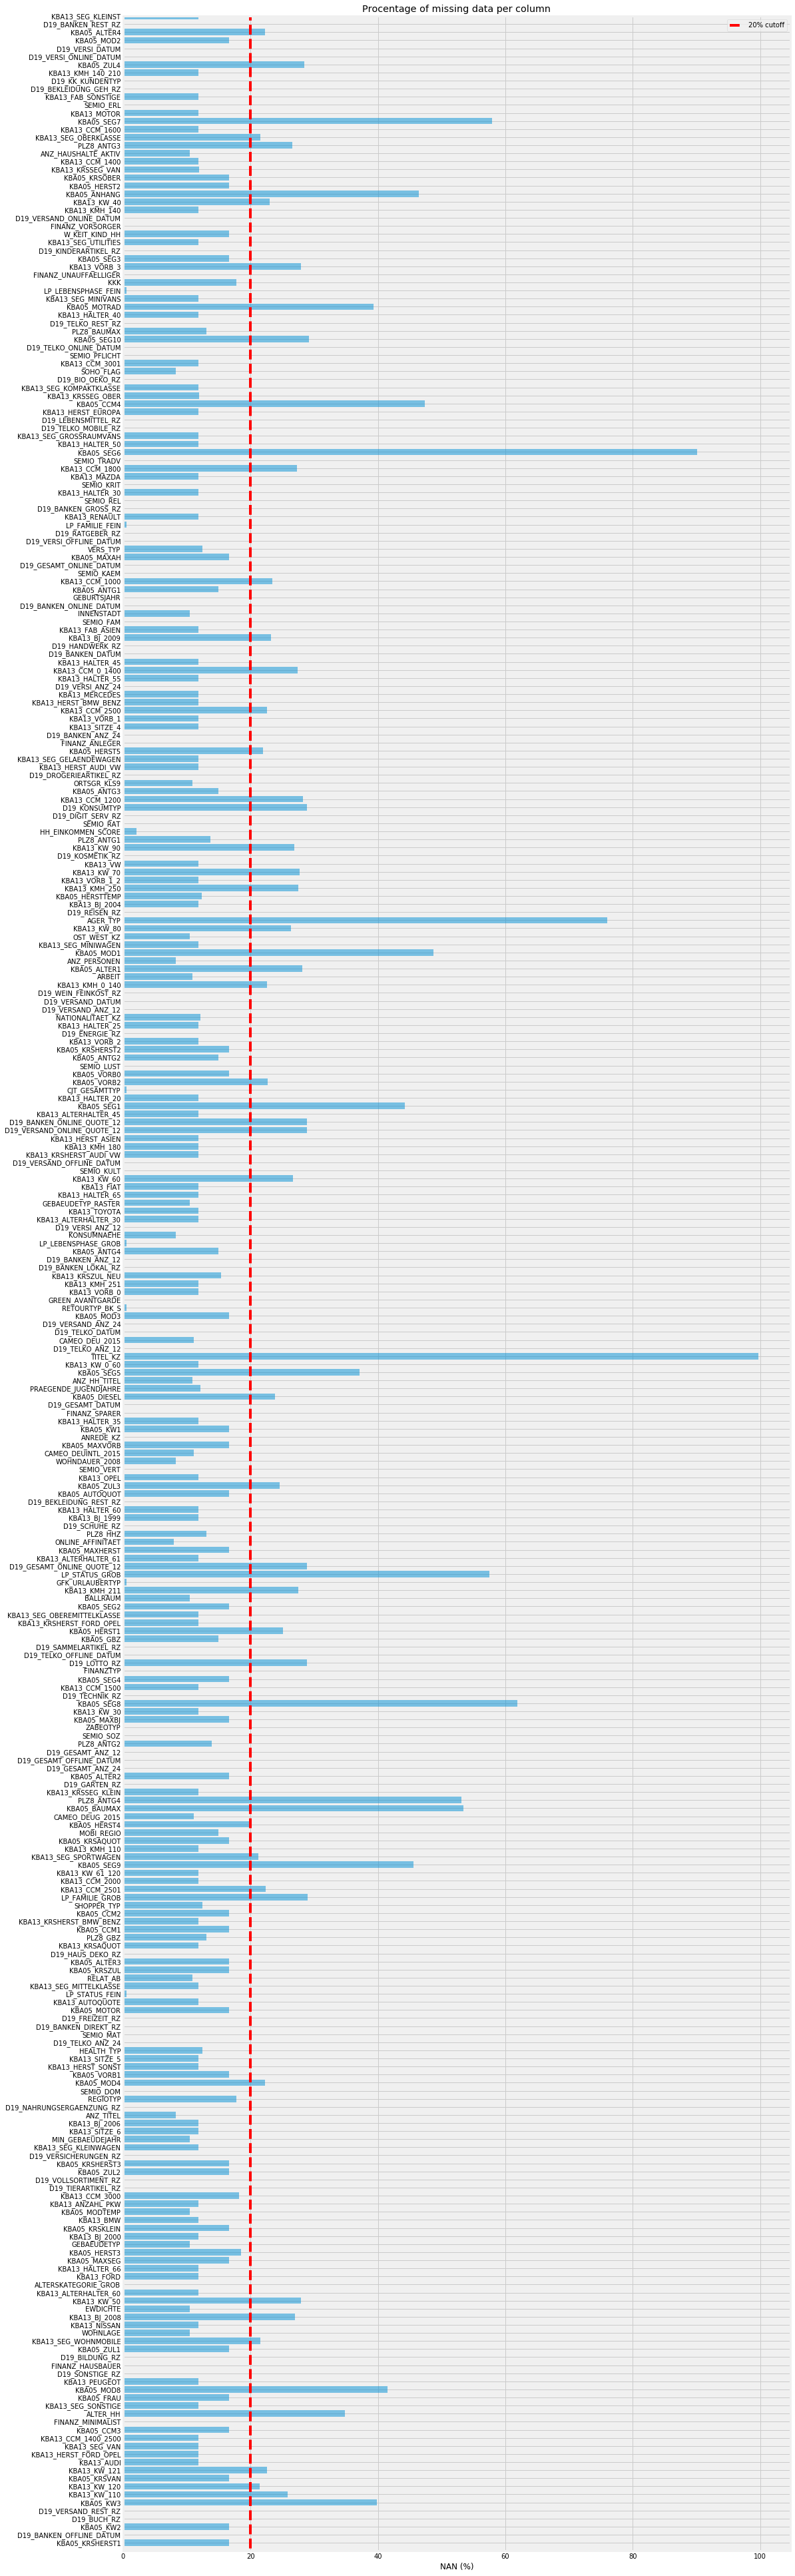

In [60]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,70))

y_pos = np.arange(len(col_names))
plt.barh(y_pos, nan_values_poc, align='center', alpha=0.5)
# visually show which features have more than 20% of missing data
plt.plot([20,20],[-5, 400],"r--", label="20% cutoff")
plt.ylim(-1,85)
plt.yticks(y_pos, col_names)
plt.xlabel('NAN (%)')
plt.title('Procentage of missing data per column')
 
plt.legend()
plt.show()

In [64]:
# count columns with missing vlaues above 20%
_ = nan_values_poc[nan_values_poc> 20].shape[0]
print(f'There are {_} columns with more than 20% missing values')
# col_names[nan_values_poc> 20]

There are 60 columns with more than 20% missing values


In [65]:
# Remove the outlier columns from the dataset. 

def remove_nan_collumns(df, limit= 0.2):
    """
    Input:
        limit: float, ratio 
    Output:
        Returns a new dataframe without columns which had more than limit missing data
    """

    no_of_rows = df.shape[0]

    for col_name in df.columns.values:
        # count how many missing values in collumn
        no_of_missing_values = df[col_name].isnull().sum()
        if no_of_missing_values > no_of_rows * limit:
            df = df.drop([col_name], axis=1)
            miss_proc = (no_of_missing_values / no_of_rows) * 100
            print("{:25s} attribute removed, {:.2f} % of data was missing".format(col_name, miss_proc))
            
    return df

In [66]:
%%time
_ = azdias.shape
print(f"Before removal shape= {_} \n")
azdias = remove_nan_collumns(azdias)
_ = azdias.shape
print(f"After removal shape= {_} \n")

Before removal shape= (891221, 314) 

KBA05_KW3                 attribute removed, 39.83 % missing data
KBA13_KW_110              attribute removed, 25.81 % missing data
KBA13_KW_120              attribute removed, 21.41 % missing data
KBA13_KW_121              attribute removed, 22.55 % missing data
ALTER_HH                  attribute removed, 34.81 % missing data
KBA05_MOD8                attribute removed, 41.52 % missing data
KBA13_SEG_WOHNMOBILE      attribute removed, 21.50 % missing data
KBA13_BJ_2008             attribute removed, 26.95 % missing data
KBA13_KW_50               attribute removed, 27.94 % missing data
KBA05_MOD4                attribute removed, 22.30 % missing data
LP_FAMILIE_GROB           attribute removed, 29.00 % missing data
KBA13_CCM_2501            attribute removed, 22.35 % missing data
KBA05_SEG9                attribute removed, 45.53 % missing data
KBA13_SEG_SPORTWAGEN      attribute removed, 21.23 % missing data
KBA05_HERST4              attribute re

In [67]:
nan_sum = azdias.isnull().sum().values 

print("{:.2f} % of all data is missing".format(100*np.sum(nan_sum) / (azdias.shape[0] * azdias.shape[1])))

8.24 % of all data is missing


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

# Part 0: Main take aways

* In both `azdias` and `customers` DataFrames X amount of unknown columns were found.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.to_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.to_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')